In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons

import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-g5onnkpe
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-g5onnkpe
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440330 sha256=7f130a362478ae833b19a466ea40f915c68b6915a38fdcfec3beaae652fe7573
  Stored in directory: /tmp/pip-ephem-wheel-cache-p04xyhhv/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.2 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Suc

2025-10-25 15:34:09.264721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761406449.454908      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761406449.508223      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path) 
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")

❌ xóa thành công /kaggle/working/.virtual_documents


In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):    
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            img = img / 255.0
            mask = mask / 255.0

            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            label = mel_label[index]

            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [4]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Train_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2017-melanoma/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 635/635 [01:56<00:00,  5.43it/s]



Đã đọc thành công 635 ảnh
Shape của images: (635, 256, 256, 3)
Shape của masks: (635, 256, 256, 1)
Shape của labels: (635,)


In [5]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Test_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 272/272 [00:49<00:00,  5.50it/s]


Đã đọc thành công 272 ảnh
Shape của images: (272, 256, 256, 3)
Shape của masks: (272, 256, 256, 1)
Shape của labels: (272,)


In [ ]:
def convert_to_gray_clahe(images_normalized):
    images_clahe = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for img in images_normalized:
        img_uint8 = np.uint8(img * 255)

        if len(img_uint8.shape) == 3:
            img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_uint8 

        img_clahe_uint8 = clahe.apply(img_gray)

        img_clahe = img_clahe_uint8.astype(np.float32) / 255.0

        images_clahe.append(img_clahe)

    return np.array(images_clahe)

train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

print(f"Shape ảnh huấn luyện sau CLAHE: {train_images_gray_clahe.shape}")

Shape ảnh huấn luyện sau CLAHE: (635, 256, 256)


In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)
 
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c5)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = SeparableConv2D(1024, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal(), dilation_rate=(2, 2))(p5)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)
    c6 = SpatialDropout2D(0.2)(c6)

    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)

    u8 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    
    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
   
    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
  
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

I0000 00:00:1761406629.591242      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 256, 256, 64)   │            137 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 256, 256, 64)   │          4,736 │ re_lu[0][0]            │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 256, 256, 64)   │              0 │ re_lu_1[0][0]          │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 128)  │         17,664 │ re_lu_2[0][0]          │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)       

 Total params: 9,358,858 (35.70 MB)

 Trainable params: 9,347,082 (35.66 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [9]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [ ]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'
checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)
start_time = time.time()
history = segunet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

print("SegUNet output shape:", segunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1761406657.099743     191 service.cc:148] XLA service 0x799194002c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761406657.100477     191 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761406659.373270     191 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1761406677.307213     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406677.533191     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406678.883415     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406679.0938

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6871 - jaccard_coefficient: 0.3108 - loss: 0.5342

E0000 00:00:1761406717.278689     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406717.518110     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406721.444217     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406721.683711     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761406728.694916     191 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6906 - jaccard_coefficient: 0.3145 - loss: 0.5300   
Epoch 1: loss improved from inf to 0.45113, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.6937 - jaccard_coefficient: 0.3179 - loss: 0.5263 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.8459 - jaccard_coefficient: 0.5095 - loss: 0.3268
Epoch 2: loss improved from 0.45113 to 0.32916, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 695ms/step - accuracy: 0.8458 - jaccard_coefficient: 0.5093 - loss: 0.3269 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8717 - jaccard_coefficient: 0.5649 - loss: 0.2793
Epoch 3: loss improved from 0.32916 to 0.27580, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step - accuracy: 0.8720 - jaccard_coefficient: 0.5651 - loss: 0.2791 - learning_rate: 0.0010
Epoch 4

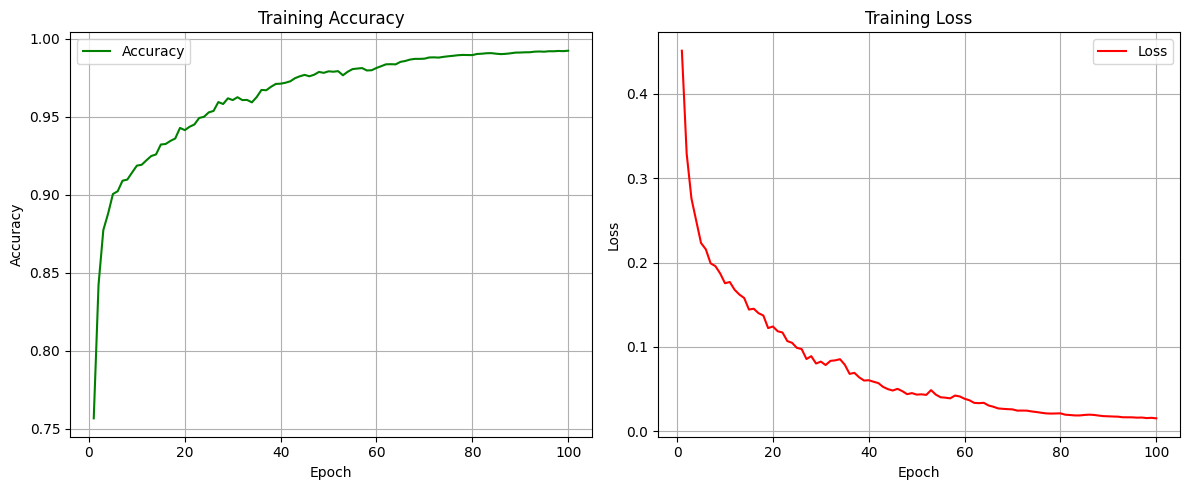

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('Gray_2750_acc_loss.png', dpi=300)
plt.show()


In [ ]:
def apply_morphology(mask, kernel_size=3, iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  

    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32) 

print("🔍 Đánh giá không hậu xử lý...")
results = segunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

print("\n🔧 Đánh giá sau Morphology...")
predictions1 = segunet.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()

    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)

refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)

accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 642ms/step - accuracy: 0.9243 - jaccard_coefficient: 0.7055 - loss: 0.1767
Không hậu xử lý - Dice Loss: 0.2093, Accuracy: 91.71%, Jaccard: 66.01%

🔧 Đánh giá sau Morphology...
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step


100%|██████████| 272/272 [00:00<00:00, 1523.18it/s]


Sau Morphology - Dice Loss: 0.1920, Accuracy: 91.75%, Jaccard: 67.79%


In [15]:
segunet.save('/kaggle/working/model/2.0-gray_2750_model.h5')
segunet.save('/kaggle/working/model/2.0-gray_2750_model.keras')